## Table of Contents

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd


sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
from bias_names import BIAS_NAMES

# Display plots inside Jupyter cell
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90


In [2]:
device_name = 'dynpase_test' # pick any name
model,no_gui = ut.open_dynapse1(gui=False, sender_port=16258, receiver_port=12457, select_device=True)

ERROR: Address already in use, please re-run open_device()!
[0]:  Bus 1 Device 29 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000000
[2]:  Bus 1 Device 30 Dynapse1DevKit serial_number 00000020
[3]:  Bus 1 Device 26 Dynapse1DevKit serial_number 00000011
Sender port: tcp://0.0.0.0:16258
Receiver port: tcp://0.0.0.0:12457
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [5]:
def organize_results(events, df_spikes=None):
    # evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
    timestamp_offset = 0 
    if df_spikes is None:
        df_spikes = pd.DataFrame()
    for evt in events:
        if timestamp_offset==0:
            timestamp_offset = evt.timestamp
        spikeData = dict(chip = evt.chip_id, 
                        core = evt.core_id,
                        neuron_id = evt.neuron_id,
                        times =(evt.timestamp-timestamp_offset)* 1e-6)
        df_spikes = pd.concat([df_spikes,pd.DataFrame(spikeData,index=[0])])
    return df_spikes

## Encoding signals with population codes

By now, you should be convinced that silicon neurons, like biological neurons, are heterogenous. However, averaging the activity of a population of heterogenous neurons, we can reduce the effect of variability.

In this tutorial, we go through different connectivity schemes: feed-forward, recurrent excitation and feedback inhibition. The aim is to highlight how and why we can combine all of them to create an EI network, a very common computational primitive in the brain.

This exercise will be mostly hands-free (minimal skeleton code) to get you used to coding from scratch (as will happen with the projects).


 ### 1. Pure feedforward
1. Allocate a cluster (i.e population) of 16 neurons in a single core.
2. Stimulate the cluster with a regular spike train of 100 Hz via excitatory synapse (you might want to use NMDA with threshold set to 0).
3. Set the network parameters to achive an average firing rate of 20 Hz.

4. Sweep over the input frequency. Plot FF curve for the population activity and the raster plot for the neurons' spike times.

In [3]:
emu_dur = 2 # in seconds
in_firing_rate = 100 # in hz

In [15]:
def generate_reg_sp_train(spikegen_gp, post_chip, rate, duration):
    # regular spike times
    spike_times = np.linspace(0, duration, duration * rate)
    # print(f"Spike times for a single spike generator ({len(spike_times)}):{spike_times}")

    # get global ids
    spgen_gids = ut.get_global_id_list(spikegen_gp.tuple_neuron_ids)

    # set spikegen ids global
    spike_ids = len(spike_times)* spgen_gids

    # set post chip
    # post_chip = DPI_neuron.chip_id
    target_chips = [post_chip]*len(spike_ids)

    return spike_times, spike_ids, target_chips
    

In [29]:
def pure_ff_bias():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    
    #------------------------AMPA parameters----------------------#
    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 7
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 255

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 0
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 0

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 0
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 0 

    #------------------------NMDA parameters----------------------#
    # first keep NMDA threshold to 0: i.e deactivate (AMPA_like) at coarse 0
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
    paramGroup.param_map["IF_NMDA_N"].fine_value = 0

    # Adjust weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 6 
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 100

    # # NMDA time constant
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80

    # NMDA gain
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 40

    #--------------------Neuron parameters--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    return paramGroup

In [48]:

# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

#-----------------------Network ----------------------------#
net_gen = n.NetworkGenerator()
# Allocate neurons of excitatory cluster
neu_chip_id = 0
neu_core_id = 1
n_exc = 16
neu_ids = np.arange(16, 16 + n_exc,1)

DPI_neuron =  n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Allocate spikegen
spgen_chip_id = 0
spgen_core_id = 1
spgen_id = [0]
spikegen = n.NeuronGroup(spgen_chip_id ,spgen_core_id,spgen_id,True) 


# Connect all2all with AMPA synpase
syn = n.Synapses(spikegen, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')
n.add_synapses(net_gen, syn)

print(f"Sanity check config:{net_gen.network}")

# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

#--------------------Set input spike train ----------------------#

# get FPGA spike_gen from model
fpga_spike_gen = model.get_fpga_spike_gen()
# # regular spike times
# spike_times = np.linspace(0, emu_dur, emu_dur *in_firing_rate)
# # print(f"Spike times for a single spike generator ({len(spike_times)}):{spike_times}")

# # get global ids
# spgen_gids = ut.get_global_id_list(spikegen.tuple_neuron_ids)

# # set spikegen ids global
# device_indices = len(spike_times)* spgen_gids

# # set post chip
# post_chip = DPI_neuron.chip_id
# target_chips = [post_chip]*len(device_indices)

isi_base = 900
repeat_mode = False
# spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, DPI_neuron.chip_id, in_firing_rate, emu_dur)
# ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)

#-----------------Tune biases-------------------------------------#
paramGroup = pure_ff_bias()
model.update_parameter_group(paramGroup, DPI_neuron.chip_id, DPI_neuron.core_id)


#--------------------Monitor ----------------------#

graph, filter_node, sink_node = ut.create_neuron_select_graph(model, DPI_neuron.tuple_neuron_ids)


results_df = pd.DataFrame()
ff_df = pd.DataFrame(columns=['in_rate', 'out_rate'])
mon_dur = 10 # in sec

for row, rate in enumerate([100]):#range(10, 400, 50)
    spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, DPI_neuron.chip_id, rate, emu_dur)
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)
    
    # start gens
    fpga_spike_gen.start()

    # Start graph 
    graph.start()

    # Clear buffer
    sink_node.get_events()
    for i in range(2):
        # get spikes every 2 seconds
        time.sleep(emu_dur)
        events = sink_node.get_events()

        # process the events
        mean_rate_pop = len(events)/n_exc/(emu_dur)
        print(f"Events:{len(events)}    Mean rate:{mean_rate_pop} Hz")
        results_df = organize_results(events, results_df)

    graph.stop()
    fpga_spike_gen.stop()

    # Organize events
    # results_df = organize_results(events, results_df)
    ff_df.loc[row] = [rate, mean_rate_pop]


Sanity check config:Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n27: [('C0c1s0', 'NMDA')]
C0c1n19: [('C0c1s0', 'NMDA')]
C0c1n18: [('C0c1s0', 'NMDA')]
C0c1n21: [('C0c1s0', 'NMDA')]
C0c1n20: [('C0c1s0', 'NMDA')]
C0c1n29: [('C0c1s0', 'NMDA')]
C0c1n30: [('C0c1s0', 'NMDA')]
C0c1n31: [('C0c1s0', 'NMDA')]
C0c1n25: [('C0c1s0', 'NMDA')]
C0c1n28: [('C0c1s0', 'NMDA')]
C0c1n17: [('C0c1s0', 'NMDA')]
C0c1n26: [('C0c1s0', 'NMDA')]
C0c1n24: [('C0c1s0', 'NMDA')]
C0c1n23: [('C0c1s0', 'NMDA')]
C0c1n22: [('C0c1s0', 'NMDA')]
C0c1n16: [('C0c1s0', 'NMDA')]

Events:599    Mean rate:18.71875 Hz
Events:624    Mean rate:19.5 Hz


In [47]:
results_df

,chip,core,neuron_id,times
0,0,1,30,0.000000
0,0,1,19,0.002797
0,0,1,20,0.003874
0,0,1,17,0.004584
0,0,1,25,0.004612
...,...,...,...,...
0,0,1,30,3.980985
0,0,1,26,3.984665
0,0,1,23,4.000201
0,0,1,21,4.001132


(0.0, 4.0)

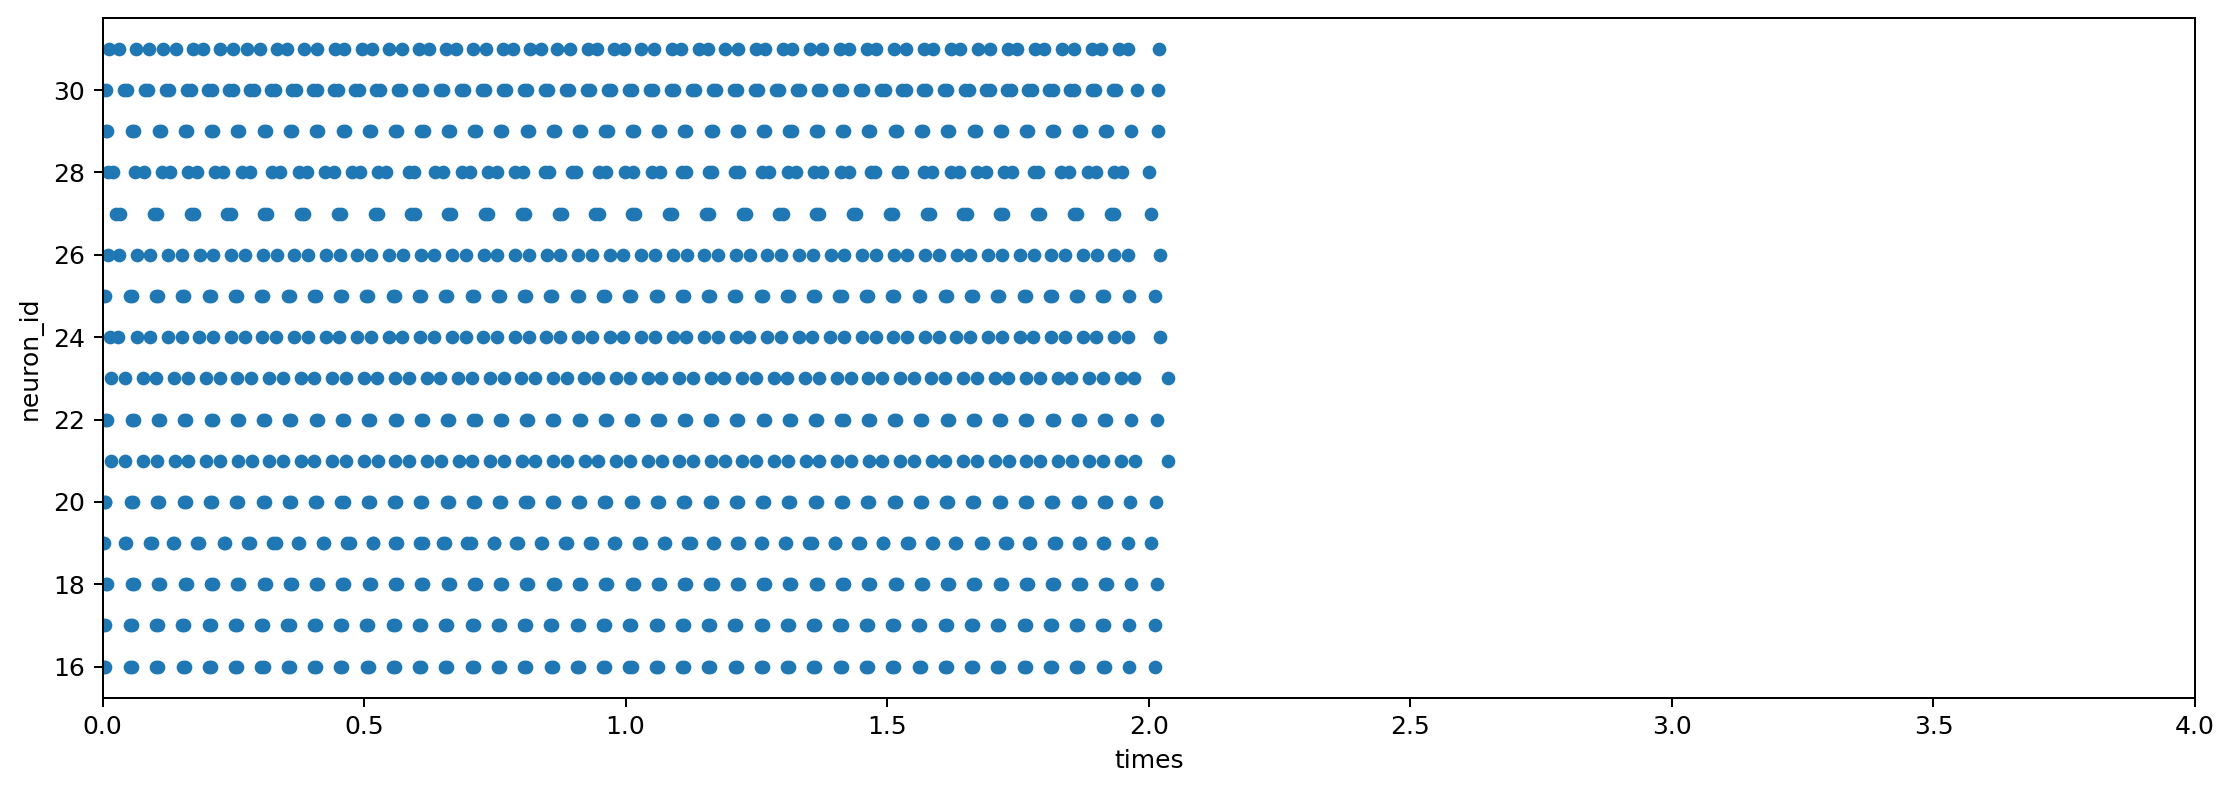

In [51]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
results_df.plot(x='times', y='neuron_id', kind='scatter', ax=ax)
plt.xlim([0,4])

(0.0, 60.0)

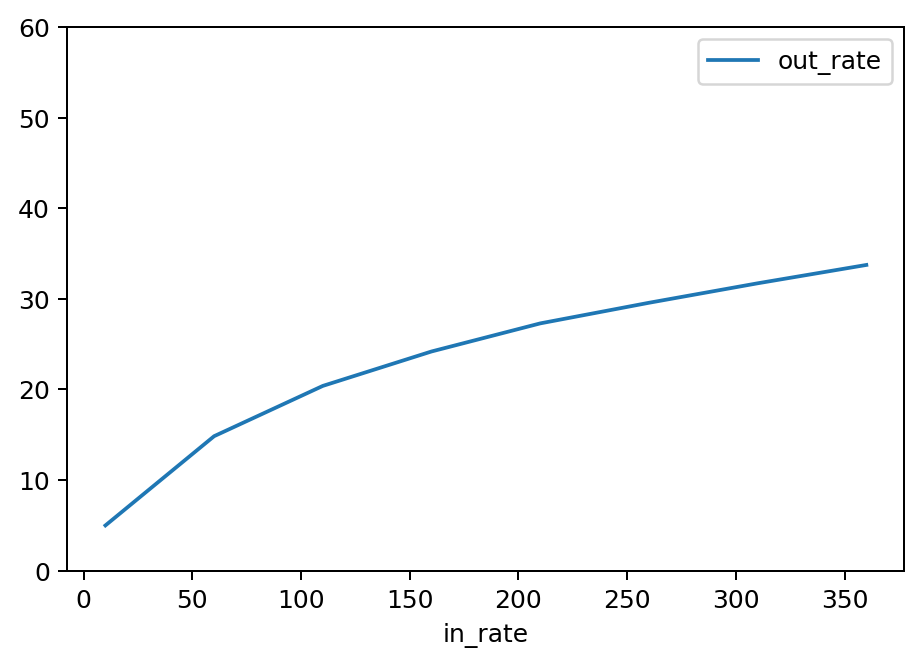

In [31]:
ff_df.plot(x='in_rate', y='out_rate', kind='line')
plt.ylim([0,60])

Q: How can you increase the gain of this network? Think topology...


### 2. Adding recurrency and self-excitation

5. Add recurrent excitatory connections to the cluster (you can use AMPA synapses for that).
6. Re-do the FF curve of this network. What can you say about the gain?

7. Make sure you provide the input for 2 seconds only then remove it. Record the population activity for 4 seconds. What do you observe?

In [36]:
def exc_rec_bias():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    
    #------------------------AMPA parameters----------------------#
    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 100

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 80

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 100

    #------------------------NMDA parameters----------------------#
    # first keep NMDA threshold to 0: i.e deactivate (AMPA_like) at coarse 0
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
    paramGroup.param_map["IF_NMDA_N"].fine_value = 0

    # Adjust weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 6 
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 100

    # # NMDA time constant
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80

    # NMDA gain
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 40

    #--------------------Neuron parameters--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    return paramGroup

In [56]:
# Input firing range
in_rates = np.arange(10, 400, 50)

# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

#-----------------------Network ----------------------------#
net_gen = n.NetworkGenerator()
# Allocate neurons of excitatory cluster
neu_chip_id = 0
neu_core_id = 1
n_exc = 16
neu_ids = np.arange(16, 16 + n_exc,1)

DPI_neuron =  n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Allocate spikegen
spgen_chip_id = 0
spgen_core_id = 1
spgen_id = [0]
spikegen = n.NeuronGroup(spgen_chip_id ,spgen_core_id,spgen_id,True) 


# Connect all2all with AMPA synpase
syn_ff = n.Synapses(spikegen, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')
n.add_synapses(net_gen, syn_ff)

# Add excitatory recurrent connections
p_ee = 0.2
# net_gen.add_connections_from_type(DPI_neuron.neurons, DPI_neuron.neurons, dyn1.Dynapse1SynType.AMPA, conn_type='all2all', p=0.2, rand_seed=100)
syn_rec = n.Synapses(DPI_neuron, DPI_neuron, dyn1.Dynapse1SynType.AMPA, conn_type='all2all', p = p_ee)
n.add_synapses(net_gen, syn_rec)

print(f"Sanity check config:{net_gen.network}")

# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

#--------------------Set input spike train ----------------------#

# get FPGA spike_gen from model
fpga_spike_gen = model.get_fpga_spike_gen()
isi_base = 900
repeat_mode = False

#-----------------Tune biases-------------------------------------#
paramGroup = exc_rec_bias()
model.update_parameter_group(paramGroup, DPI_neuron.chip_id, DPI_neuron.core_id)


#--------------------Monitor ----------------------#

graph, filter_node, sink_node = ut.create_neuron_select_graph(model, DPI_neuron.tuple_neuron_ids)


results_df = pd.DataFrame()
ff_df_rec = pd.DataFrame(columns=['in_rate', 'out_rate'])
mon_dur = 4 # in sec
for row, rate in enumerate([100]): #in_rates
    spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, DPI_neuron.chip_id, rate, emu_dur)
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)
    
    # start gens
    fpga_spike_gen.start()

    # Start graph 
    graph.start()

    # Clear buffer
    sink_node.get_events()

    for i in range(4):
        # get spikes every 2 seconds
        time.sleep(emu_dur)
        events = sink_node.get_events()

        # process the events
        mean_rate_pop = len(events)/n_exc/(emu_dur)
        print(f"Events:{len(events)}    Mean rate:{mean_rate_pop} Hz")
        results_df = organize_results(events, results_df)

    graph.stop()
    fpga_spike_gen.stop()
    # Organize events
    # results_df = organize_results(events, results_df)
    ff_df_rec.loc[row] = [rate, mean_rate_pop]


Sanity check config:Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n24: [('C0c1s0', 'NMDA'), ('C0c1n17', 'AMPA'), ('C0c1n25', 'AMPA')]
C0c1n17: [('C0c1s0', 'NMDA'), ('C0c1n31', 'AMPA'), ('C0c1n23', 'AMPA'), ('C0c1n30', 'AMPA')]
C0c1n22: [('C0c1s0', 'NMDA'), ('C0c1n24', 'AMPA')]
C0c1n20: [('C0c1s0', 'NMDA'), ('C0c1n21', 'AMPA'), ('C0c1n22', 'AMPA'), ('C0c1n28', 'AMPA'), ('C0c1n16', 'AMPA')]
C0c1n23: [('C0c1s0', 'NMDA'), ('C0c1n29', 'AMPA'), ('C0c1n19', 'AMPA'), ('C0c1n22', 'AMPA')]
C0c1n27: [('C0c1s0', 'NMDA'), ('C0c1n27', 'AMPA'), ('C0c1n20', 'AMPA'), ('C0c1n24', 'AMPA')]
C0c1n18: [('C0c1s0', 'NMDA'), ('C0c1n25', 'AMPA'), ('C0c1n23', 'AMPA')]
C0c1n31: [('C0c1s0', 'NMDA'), ('C0c1n28', 'AMPA'), ('C0c1n27', 'AMPA'), ('C0c1n25', 'AMPA'), ('C0c1n23', 'AMPA'), ('C0c1n19', 'AMPA'), ('C0c1n16', 'AMPA')]
C0c1n28: [('C0c1s0', 'NMDA'), ('C0c1n22', 'AMPA'), ('C0c1n26', 'AMPA'), ('C0c1n24', 'AMPA')]
C0c1n30: [('C0c1s0', 'NMDA'), ('C0c1n25', 'AMPA'), ('

Text(0.5, 1.0, 'P_ee = 0.1')

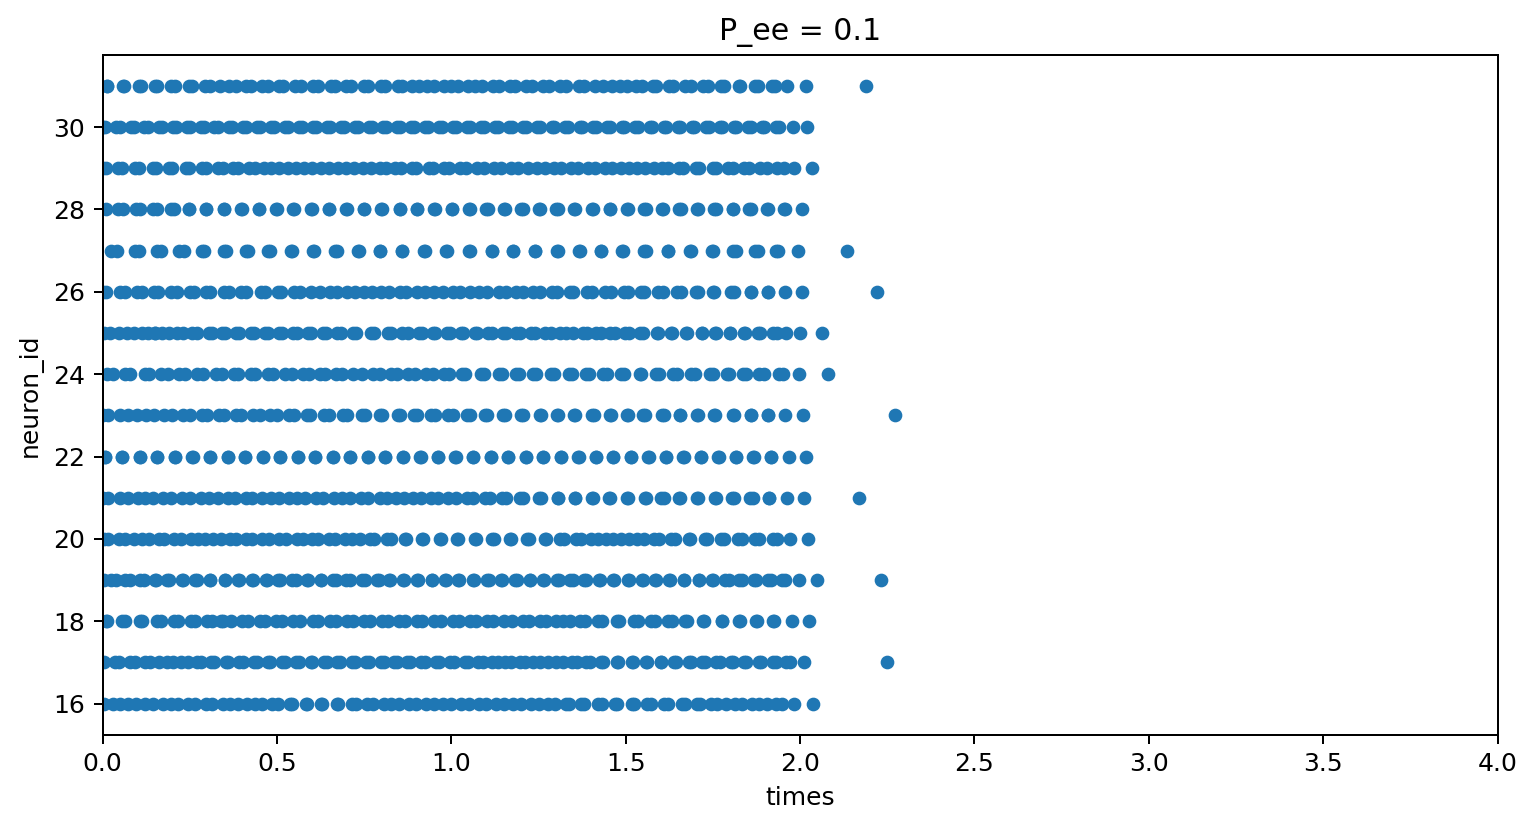

In [57]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
results_df.plot(x='times', y='neuron_id', kind='scatter', ax=ax)
plt.xlim([0,4])
plt.title("P_ee = 0.1")

In [ ]:
# samna.device.close_device(model)